In [1]:
# 기본 설정
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict, Counter
from datetime import datetime

TRAIN_DATA_PATH = '/opt/ml/input/data/train_data.csv'
TEST_DATA_PATH = '/opt/ml/input/data/test_data.csv'

train_data_df = pd.read_csv(TRAIN_DATA_PATH)
test_data_df = pd.read_csv(TEST_DATA_PATH)

#  🥝 KnowledgeTag 관련
## ⚡ KnowledgeTag 별 문제의 수

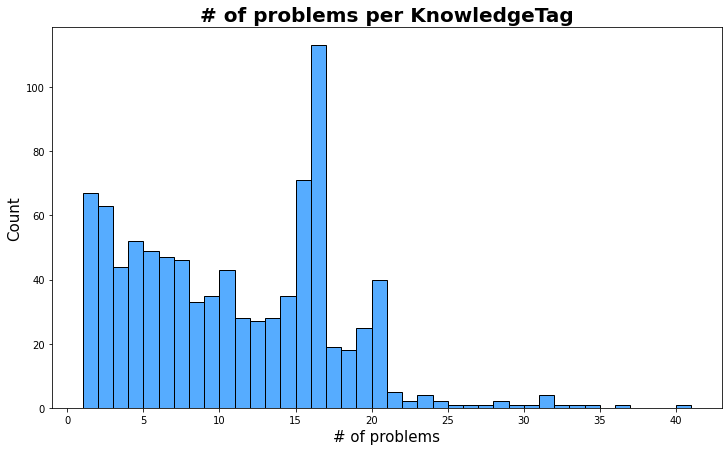

In [2]:
problems_by_tag = train_data_df.groupby("KnowledgeTag")["assessmentItemID"].apply(set).apply(len)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(problems_by_tag, binwidth=1, color="dodgerblue")
ax.set_xlabel("# of problems", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.set_title("# of problems per KnowledgeTag", fontsize=20, fontweight="semibold")
plt.show()

## ⚡ KnowledgeTag 별 문제풀이 시간 분포 (scatter, 평균값)

In [27]:
problem_times = train_data_df[["userID", "assessmentItemID", "testId", "Timestamp", "KnowledgeTag"]]
time_stamp = problem_times["Timestamp"].values
time_diff = list()
for idx in tqdm(range(len(time_stamp) - 1)):
    cur_time = time_stamp[idx]
    next_time = time_stamp[idx + 1]
    
    d1 = datetime.strptime(next_time, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(cur_time, "%Y-%m-%d %H:%M:%S")
    
    diff = int((d1 - d2).total_seconds())
    if diff > 300 or diff < 0:
        diff = 0
    time_diff.append(diff)
time_diff.append(0)
problem_times["time_spend"] = time_diff
    

100%|██████████| 2266585/2266585 [00:44<00:00, 50827.87it/s]


In [38]:
problem_spent = problem_times.groupby("KnowledgeTag")["time_spend"].apply(list)
time_by_tag = list()

# 태그별로 문제풀이 평균시간 구하기
for times in tqdm(problem_spent):
    # 시간이 0초를 넘는 것만 고려
    times = np.array(times)
    valid_idx = np.where(times > 0)
    valid_time = times[valid_idx]
    
    # 현재 태그를 푸는데 걸린 시간들의 평균
    time_by_tag.append(np.mean(valid_time))

100%|██████████| 912/912 [00:00<00:00, 4197.07it/s]


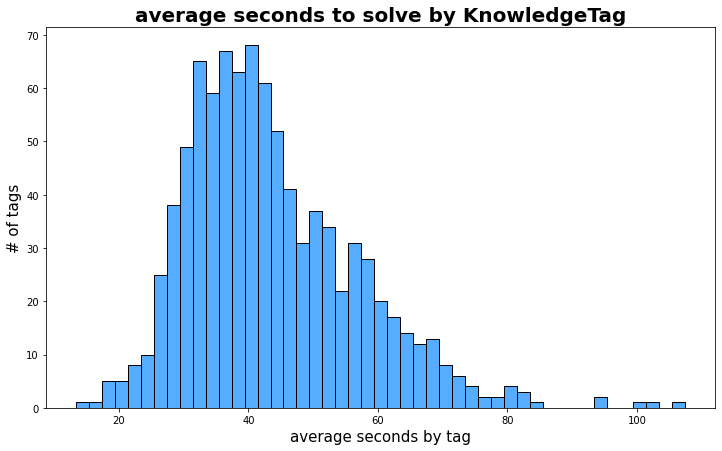

In [46]:
# 시각화: 태그별로 문제 풀이를 하는데 걸리는 시간 분포
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(time_by_tag, binwidth=2, color="dodgerblue")
ax.set_xlabel("average seconds by tag", fontsize=15)
ax.set_ylabel("# of tags", fontsize=15)
ax.set_title("average seconds to solve by KnowledgeTag", fontsize=20, fontweight="semibold")
plt.show()

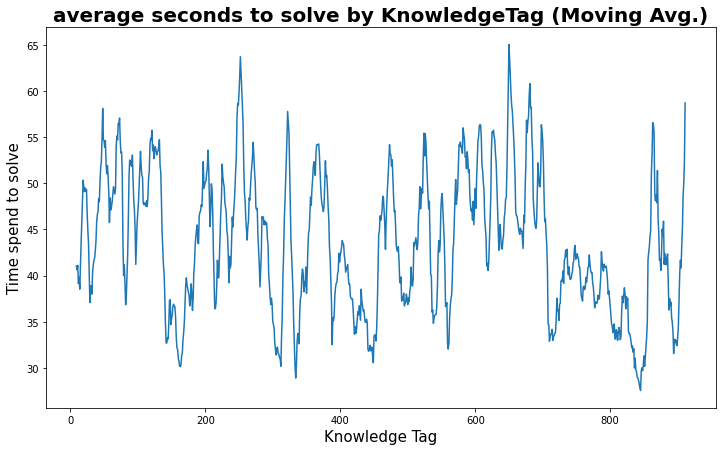

In [71]:
# 시각화: 태그 번호의 증가와 그 태그를 푸는데 걸리는 평균 시간과의 관계 시각화 (이동평균)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(pd.Series(time_by_tag).rolling(10).mean())
ax.set_xlabel("Knowledge Tag", fontsize=15)
ax.set_ylabel("Time spend to solve", fontsize=15)
ax.set_title("average seconds to solve by KnowledgeTag (Moving Avg.)", fontsize=20, fontweight="semibold")
plt.show()

## ⚡ KnowledgeTag 별 정답비율

In [72]:
submission_by_tag = train_data_df.groupby("KnowledgeTag")["answerCode"].apply(list)
answer_acc = list()

for tag_idx, tag_result in tqdm(zip(submission_by_tag.index, submission_by_tag.values)):
    answer_acc.append(sum(tag_result) / len(tag_result))

912it [00:00, 31053.28it/s]


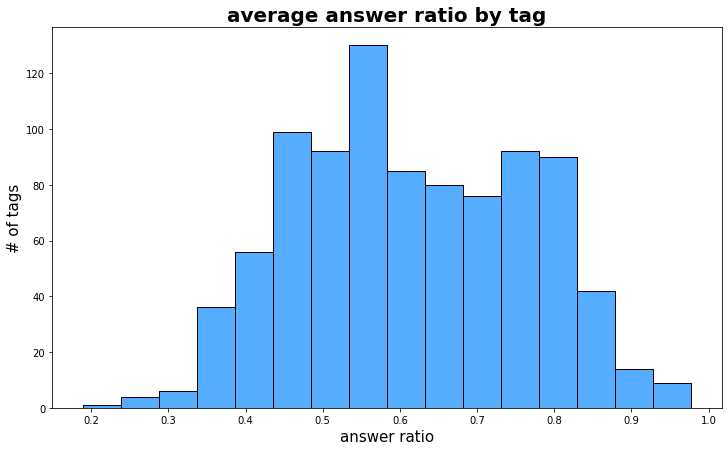

In [78]:
# 시각화: 태그별 정답비율 분포
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(answer_acc, color="dodgerblue")
ax.set_xlabel("answer ratio", fontsize=15)
ax.set_ylabel("# of tags", fontsize=15)
ax.set_title("average answer ratio by tag", fontsize=20, fontweight="semibold")
plt.show()

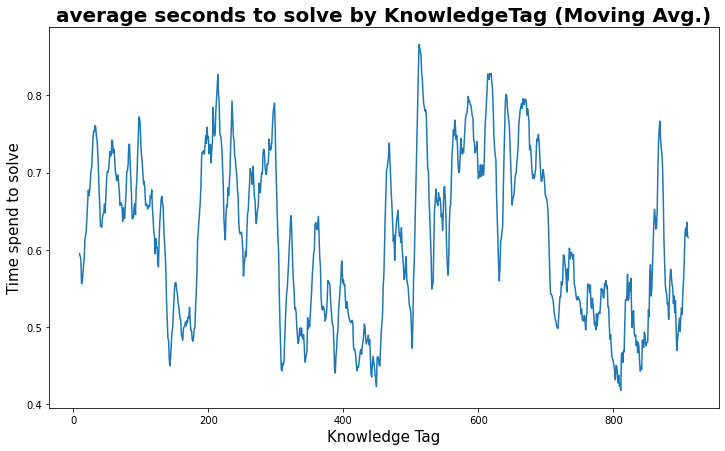

In [79]:
# 시각화: 태그 번호의 증가와 그 태그를 푸는데 걸리는 평균 시간과의 관계 시각화 (이동평균)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(pd.Series(answer_acc).rolling(10).mean())
ax.set_xlabel("Knowledge Tag", fontsize=15)
ax.set_ylabel("Time spend to solve", fontsize=15)
ax.set_title("average seconds to solve by KnowledgeTag (Moving Avg.)", fontsize=20, fontweight="semibold")
plt.show()

## ⚡ KnowledgeTag 와 대분류의 상관관계

In [81]:
class_data_df = train_data_df.copy()
class_data_df["class"] = class_data_df["assessmentItemID"].str[2]

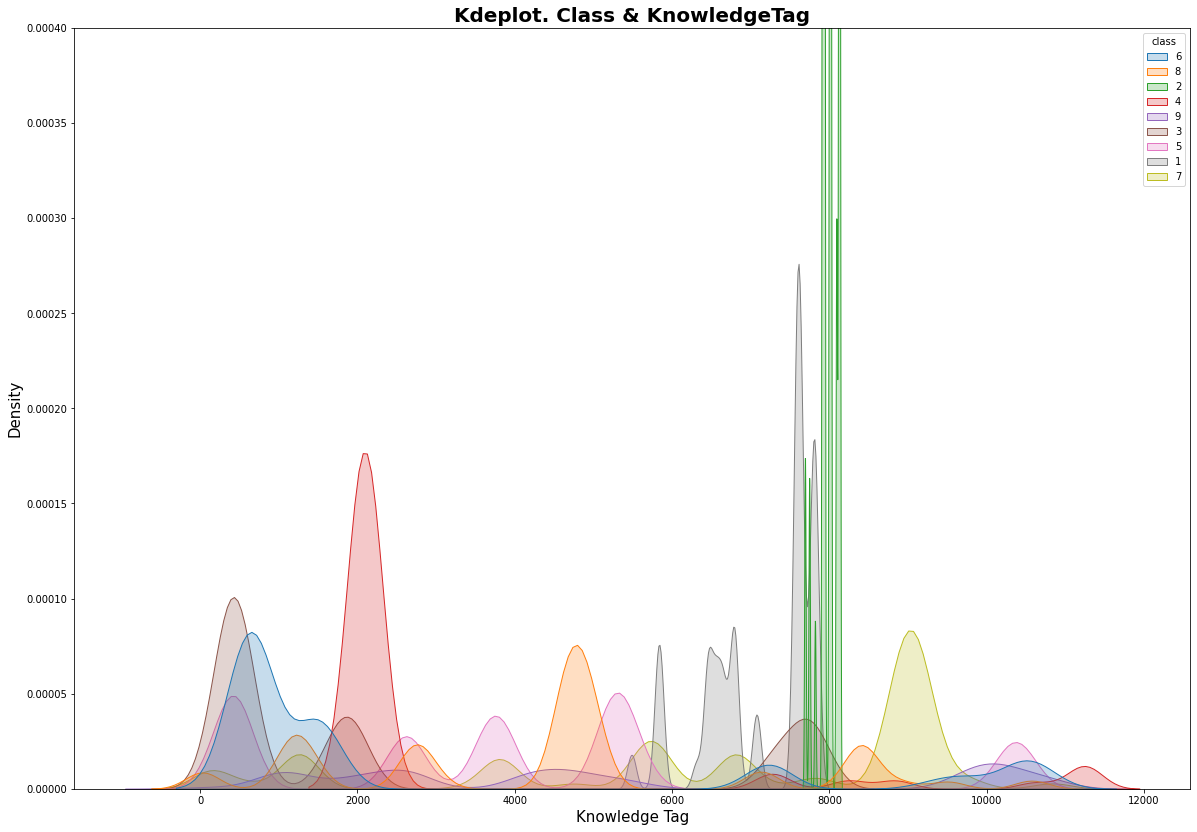

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(20, 14))
sns.kdeplot(data=class_data_df, x="KnowledgeTag", hue="class", multiple="layer", cumulative=False, fill=True)
ax.set_ylim(0, 0.0004)
ax.set_xlabel("Knowledge Tag", fontsize=15)
ax.set_ylabel("Density", fontsize=15)
ax.set_title("Kdeplot. Class & KnowledgeTag", fontsize=20, fontweight="semibold")
plt.show()

# 🍇 testId 관련
## ⚡ testId 별로 KnowledgeTag 의 수 분포

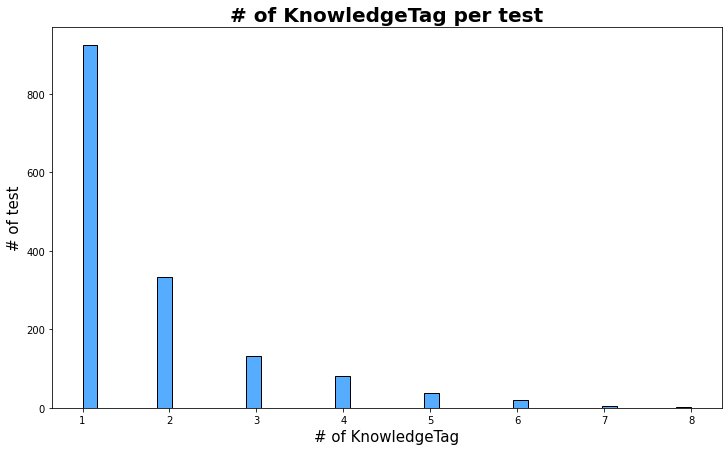

In [128]:
tag_by_id = train_data_df.groupby("testId")["KnowledgeTag"].apply(set).apply(len)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(tag_by_id.values, color="dodgerblue")
ax.set_xlabel("# of KnowledgeTag", fontsize=15)
ax.set_ylabel("# of test", fontsize=15)
ax.set_title("# of KnowledgeTag per test", fontsize=20, fontweight="semibold")
plt.show()

## ⚡ testId 별 문항의 수 분포

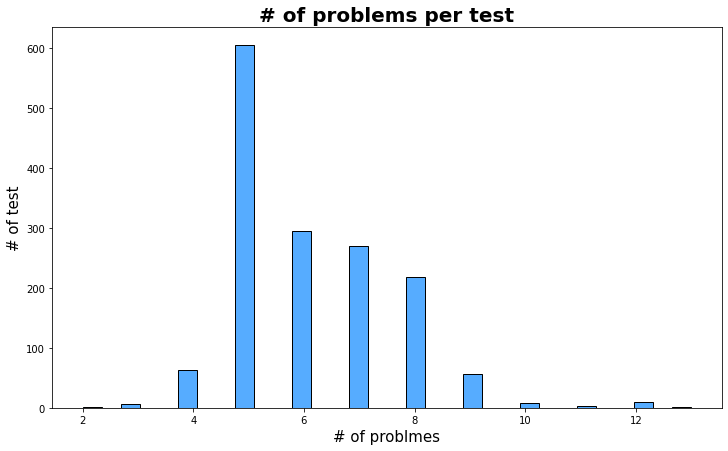

In [130]:
problem_by_id = train_data_df.groupby("testId")["assessmentItemID"].apply(set).apply(len)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.histplot(problem_by_id.values, color="dodgerblue")
ax.set_xlabel("# of problmes", fontsize=15)
ax.set_ylabel("# of test", fontsize=15)
ax.set_title("# of problems per test", fontsize=20, fontweight="semibold")
plt.show()

## ⚡ testId 별 정답률

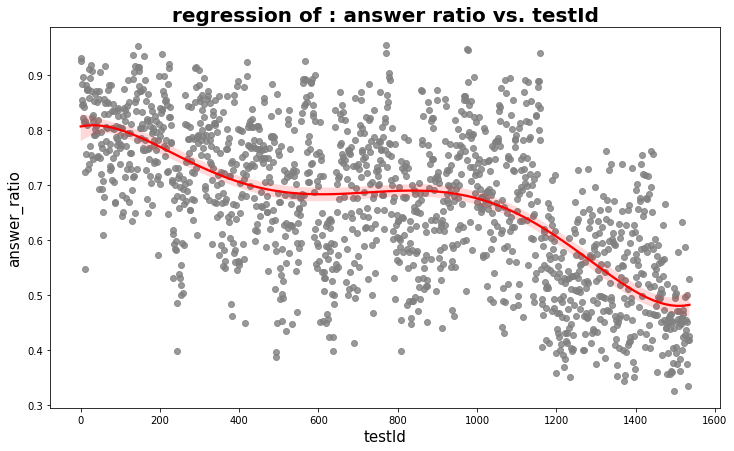

In [165]:
sub_by_id = train_data_df.groupby("testId")["answerCode"].apply(list)
sub_by_id = sub_by_id.sort_index()

acc = list()
for result in sub_by_id:
    acc.append(sum(result) / len(result))
    
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.regplot(x=np.arange(len(acc)), y=acc, ax=ax, line_kws={'color':'red'}, scatter_kws={'color':'grey'}, order=5)
ax.set_xlabel("testId", fontsize=15)
ax.set_ylabel("answer_ratio", fontsize=15)
ax.set_title("regression of : answer ratio vs. testId", fontsize=20, fontweight="semibold")
plt.show()

## ⚡  testId 의 시도 횟수 분포

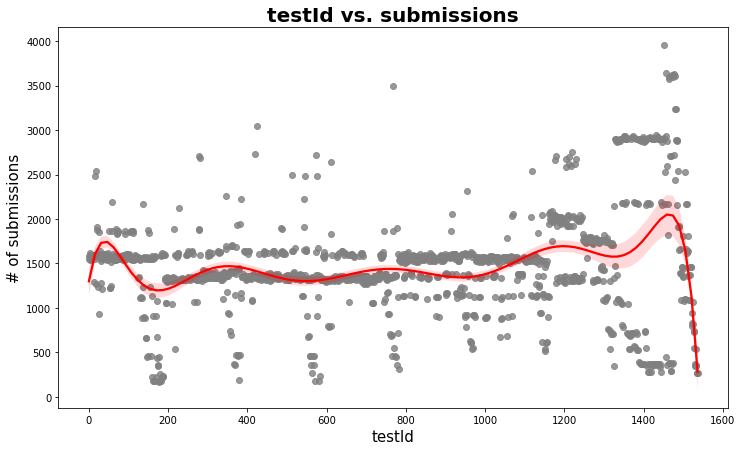

In [180]:

sub_by_id = train_data_df.groupby("testId")["answerCode"].apply(list).apply(len)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
# sns.scatterplot(x=np.arange(len(sub_by_id)))
sns.regplot(x=np.arange(len(sub_by_id.values)), y=sub_by_id.values, ax=ax, line_kws={'color':'red'}, scatter_kws={'color':'grey'}, order=10)
ax.set_xlabel("testId", fontsize=15)
ax.set_ylabel("# of submissions", fontsize=15)
ax.set_title("testId vs. submissions", fontsize=20, fontweight="semibold")
plt.show()

# 🍋 assessmentItemID 관련
## ⚡ assessmentItemID 별 정답률